In [1]:
import torch
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs

import os

os.chdir("/home/s2113174/Projects-1")

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$\frac{du}{dt} - \alpha cos(2\pi t)=0$$

with solution 
$$ u(t) = \alpha \frac{sin ( 2 \pi t )}{2 \pi}$$

## The Problem consist in infering $ \alpha $

In [2]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        for param in self.parameters():
            if len(param.shape) > 1:
                torch.nn.init.xavier_normal_(param)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [3]:
def DE(self,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = u_t - pr*torch.cos( 2*torch.pi *t)
    return f

In [4]:
DNN.DE = DE

In [5]:
def sample_ic(size):
    return np.zeros(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return min + np.random.rand(size)*max

In [6]:
def data_pde(size,maxl,minp,maxp):
    t, param = samples_space(size,maxl),samples_param(minp,maxp,size)

    X_u_train = torch.from_numpy(np.concatenate((t.reshape(-1,1),param.reshape(-1,1)),axis=1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

def data_ic(size):
    ic = sample_ic(size)

    X_u_train = torch.from_numpy(ic.reshape(-1,1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

In [7]:
def test_set(max_space = 2,obs = 1,param = 1 ,mean = 0,std = 0):

    t= np.linspace(0,max_space,obs)

    sol = (param/ (2*np.pi))*np.sin(2*np.pi*t)

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t,noise_sol_test


def data(max_space = 2,obs = 1,param = 1 ,mean = 0,std = 0.1):

    t= np.linspace(0,max_space,obs)

    sol = (param/ (2*np.pi))*np.sin(2*np.pi*t)

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    x,y = torch.tensor(t).float().reshape(-1,1),torch.tensor(noise_sol_test).float().reshape(-1,1)
    
    X_u_train = TensorDataset(x,y)

    X_u_train = DataLoader(X_u_train,batch_size=obs)

    return X_u_train

In [8]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):
    data_pde_, data_ic_ = data_pde(size,maxl,minp,maxp),data_ic(size)
    
    for (x, y),(ic,yic) in zip(data_pde_, data_ic_):

        ic,t, param = Variable(ic,requires_grad=True),Variable(x[:,0].reshape(-1,1),requires_grad=True),Variable(x[:,1].reshape(-1,1),requires_grad=True)
        
        def loss_func_train():
            
            optimizer.zero_grad()

            ic_pred,f_pred = pinn(torch.cat([ic, param], dim=1)),pinn.DE(t,param)

            loss_u_ic,loss_f = loss(ic_pred,yic),loss(f_pred,y)

            Loss =  loss_f + loss_u_ic

            if i % 10 == 0:
                    print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
            
            Loss.backward() 
        
            return Loss

        optimizer.step(loss_func_train) 
        
        oupt = pinn(torch.cat([ic, param], dim=1))  

        loss_val = loss_func_train() 

        itr_loss += loss_val.item()  

In [9]:
# Number of observations
epochs = 100
nobs = 1000
lr = 0.01

min_param , max_param = 0, 10

space = 3

layers = [2] + 2*[50] + [1]

model = DNN(layers)
loss = torch.nn.MSELoss(reduction ='mean')

In [10]:
optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

#optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [11]:
train(epochs, model,loss,optimizer,nobs,space,min_param , max_param)

# model.load_state_dict(torch.load("Param_model.pt"))
# model.eval()

Starting Training
Iter 0, Loss: 1.68528e+01, Loss_ic: 3.48747e-02, Loss_f: 1.68179e+01
Iter 0, Loss: 1.68518e+01, Loss_ic: 3.40377e-02, Loss_f: 1.68177e+01
Iter 0, Loss: 1.68473e+01, Loss_ic: 3.04033e-02, Loss_f: 1.68169e+01
Iter 0, Loss: 1.68131e+01, Loss_ic: 5.50606e-03, Loss_f: 1.68076e+01
Iter 0, Loss: 1.68128e+01, Loss_ic: 5.40317e-03, Loss_f: 1.68074e+01
Iter 0, Loss: 1.68116e+01, Loss_ic: 4.96085e-03, Loss_f: 1.68067e+01
Iter 0, Loss: 1.68033e+01, Loss_ic: 2.65359e-03, Loss_f: 1.68007e+01
Iter 0, Loss: 1.68030e+01, Loss_ic: 2.61572e-03, Loss_f: 1.68004e+01
Iter 0, Loss: 1.68014e+01, Loss_ic: 2.45597e-03, Loss_f: 1.67990e+01
Iter 0, Loss: 1.67937e+01, Loss_ic: 2.30239e-03, Loss_f: 1.67914e+01
Iter 0, Loss: 1.67932e+01, Loss_ic: 2.31175e-03, Loss_f: 1.67909e+01
Iter 0, Loss: 1.67896e+01, Loss_ic: 2.44429e-03, Loss_f: 1.67872e+01
Iter 0, Loss: 1.67637e+01, Loss_ic: 9.93354e-03, Loss_f: 1.67538e+01
Iter 0, Loss: 1.67634e+01, Loss_ic: 9.98285e-03, Loss_f: 1.67534e+01
Iter 0, Loss: 1.

/home/s2113174/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iter 0, Loss: 1.66866e+01, Loss_ic: 9.73231e-04, Loss_f: 1.66856e+01
Iter 0, Loss: 1.66862e+01, Loss_ic: 9.90526e-04, Loss_f: 1.66852e+01
Iter 0, Loss: 1.66839e+01, Loss_ic: 1.12351e-03, Loss_f: 1.66828e+01
Iter 0, Loss: 1.66837e+01, Loss_ic: 1.12612e-03, Loss_f: 1.66826e+01
Iter 0, Loss: 1.66827e+01, Loss_ic: 1.13817e-03, Loss_f: 1.66815e+01
Iter 0, Loss: 1.66777e+01, Loss_ic: 1.19156e-03, Loss_f: 1.66765e+01
Iter 0, Loss: 1.66773e+01, Loss_ic: 1.16457e-03, Loss_f: 1.66762e+01
Iter 0, Loss: 1.66759e+01, Loss_ic: 1.04504e-03, Loss_f: 1.66749e+01
Iter 0, Loss: 1.66689e+01, Loss_ic: 3.67737e-03, Loss_f: 1.66652e+01
Iter 0, Loss: 1.66688e+01, Loss_ic: 3.62695e-03, Loss_f: 1.66652e+01
Iter 0, Loss: 1.66683e+01, Loss_ic: 3.40602e-03, Loss_f: 1.66649e+01
Iter 0, Loss: 1.66661e+01, Loss_ic: 2.36933e-03, Loss_f: 1.66637e+01
Iter 0, Loss: 1.66660e+01, Loss_ic: 2.34355e-03, Loss_f: 1.66637e+01
Iter 0, Loss: 1.66656e+01, Loss_ic: 2.23142e-03, Loss_f: 1.66634e+01
Iter 0, Loss: 1.66626e+01, Loss_ic

In [25]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_1'))

In [26]:
data_pde_ = data_pde(nobs,space,min_param , max_param)

t,param = next(iter(data_pde_))

t, param = Variable(t[:,0].reshape(-1,1),requires_grad=True),Variable(t[:,1].reshape(-1,1),requires_grad=True)


In [27]:
f_pred = model.DE(t,param)

h1.remove()

ic_pred = model(torch.cat([torch.zeros_like(param), param], dim=1))

loss_u_ic,loss_f = loss(ic_pred,torch.zeros_like(ic_pred)),loss(f_pred,torch.zeros_like(f_pred))

In [31]:
df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

#df_f_2 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

#ddf_ff_2 = grad(df_f_2, ic_pred, torch.ones_like(df_f_2))[0]

In [35]:
wt,bias = model.layers[-1].weight, model.layers[-1].bias

param_MAP = torch.cat((wt,bias.reshape(1,1)),1) 

nparam = param_MAP.reshape(-1).shape

In [36]:
df_theta = torch.cat((forw_activation['layers.activation_1'],torch.ones_like(ddf_ff_1)),1)

H = (nobs/2)*torch.sum(df_theta*ddf_ff_1*df_theta,axis=0)

print(H)

tensor([ 980.4095,  997.3158,  999.8784, 1000.0000,  992.0839,  999.9936,
         999.8754,  999.7734,  994.8450,  999.5013,  965.7816,  139.4676,
         998.6441,  926.1995,  940.8390,  670.7416,  992.5685,  994.7382,
         999.7524,  999.8637,  990.9568,  997.9500,  979.2992,  839.9318,
         999.8949,  913.8722, 1000.0000, 1000.0000,  791.7939,  830.9116,
         995.7245,  998.4598,  992.3414,  239.3941,  406.5838,  992.5878,
         885.6454, 1000.0001,  932.6146,  998.4505,  922.6512,  384.6780,
         999.7444,   15.9614, 1000.0001,  991.2941, 1000.0001,  999.5840,
         999.7912,  925.0798, 1000.0001])


In [37]:
def sigma_noise():
    return _sigma_noise

def _H_factor():
    sigma2 = sigma_noise().square()
    return 1 / sigma2 / temperature

def prior_precision_diag(prior_precision,n_params):
    """Obtain the diagonal prior precision \\(p_0\\) constructed from either
    a scalar, layer-wise, or diagonal prior precision.

    Returns
    -------
    prior_precision_diag : torch.Tensor
    """
    if len(prior_precision) == 1:  # scalar
        return prior_precision * torch.ones(n_params, device=device)

    elif len(prior_precision) == n_params:  # diagonal
        return prior_precision

    # elif len(prior_precision) == n_layers:  # per layer
    #     n_params_per_layer = parameters_per_layer(self.model)
    #     return torch.cat([prior * torch.ones(n_params, device=self._device) for prior, n_params
    #                         in zip(self.prior_precision, n_params_per_layer)])

    # else:
    #     raise ValueError('Mismatch of prior and model. Diagonal, scalar, or per-layer prior.')

_sigma_noise=torch.tensor([1])
temperature=torch.tensor([1])
prior_precision=torch.tensor([1])

prior_precision_diag = prior_precision_diag(prior_precision,nparam)

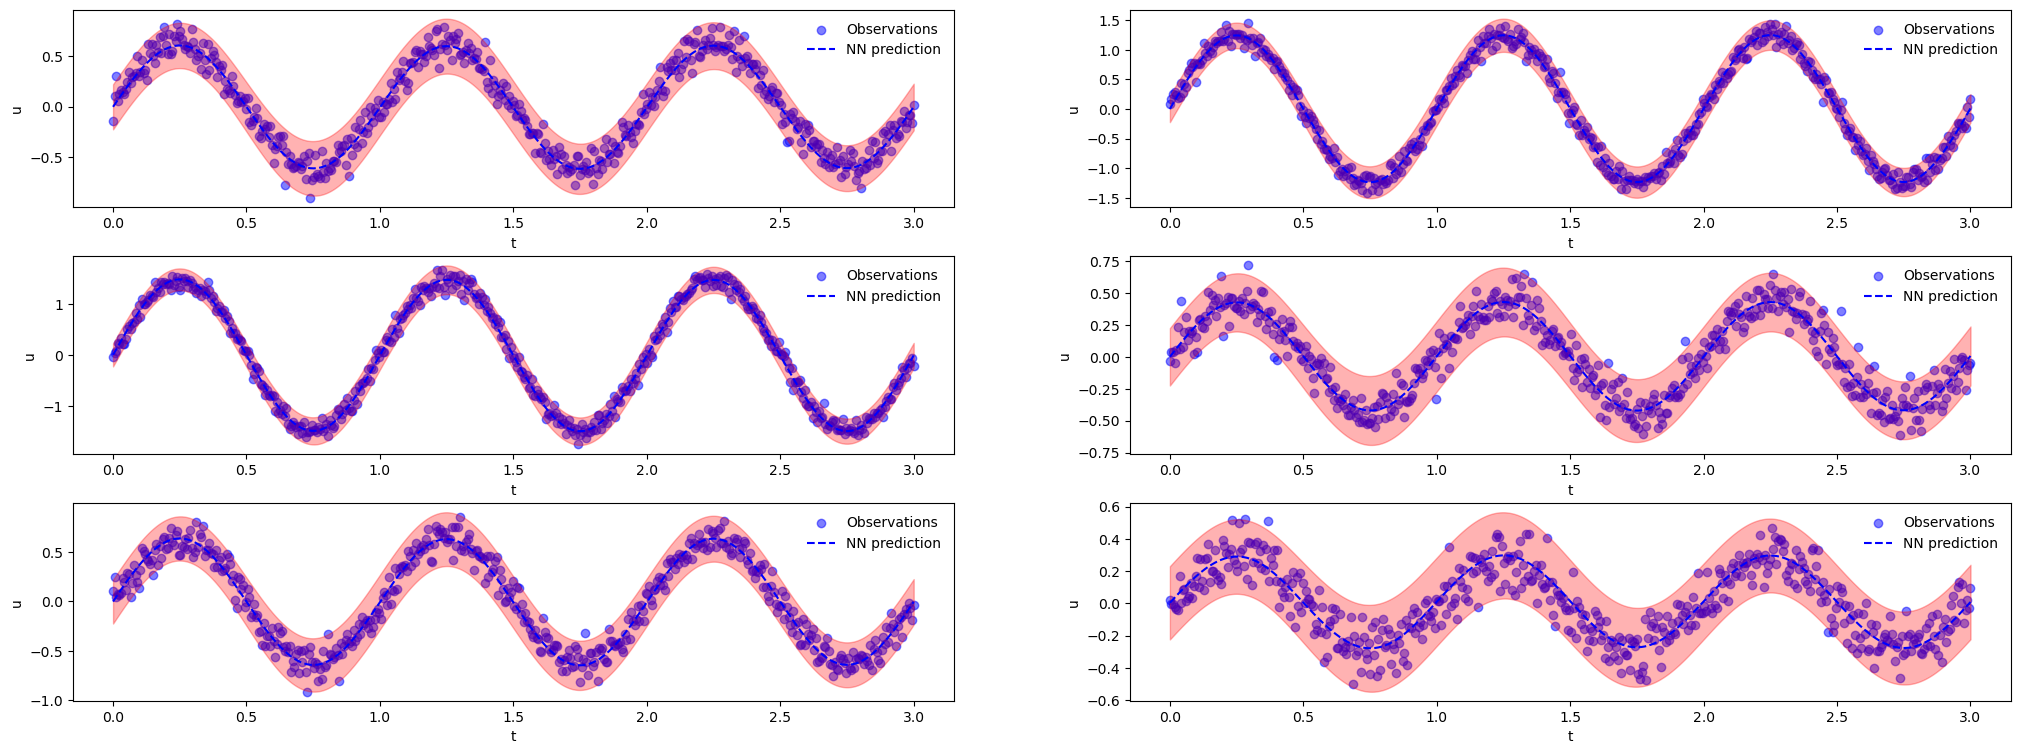

In [125]:
import matplotlib.pyplot as plt
from matplotlib import cm


param_trained =  samples_param(min_param , max_param,6)
ns, mean, std = 3, 0,0.1

# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,pr in enumerate(param_trained):

    t, noise_sol_test = test_set(ns,500,pr,mean,std)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr)))


    ######################################################################################

    forw_activation_ = {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_1'))

    f  = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    h1.remove()

    phi = forw_activation['layers.activation_1']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * H + prior_precision_diag


    post_variance = 1 / post_presicion

    functional_var = torch.einsum('ncp,p,nkp->nck', Js, post_variance, Js)

    #######################################################################################
    f_mu = f.reshape(-1)
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy().reshape(-1)

    plt.subplot(8, 2, n + 1)

    plt.scatter(t,noise_sol_test, label = "Observations",color= "blue",alpha = 0.5)
    plt.plot(t, f_mu, "--",label='NN prediction',color="blue")
    plt.fill_between(t, f_mu+f_sigma,f_mu-f_sigma,alpha=0.3, color = "red")

    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)